In [14]:
# Imports
from pyspark.sql import SparkSession
import zipfile
from pyspark.sql.functions import *
from pyspark.sql.window import Window

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from datetime import datetime, timedelta

In [15]:
# Creating a spark session
spark_session = SparkSession.builder.appName("project_EDA").getOrCreate()

In [16]:
spark_session

In [17]:
# read data

In [18]:
df = spark_session.read.format("csv").option("header","true").option("delimiter", ",").load("/Users/mudit.rathore/omscs/courses/cse_6242_DVA/project/data/*.csv")

In [19]:
# total_distinct User count
df.select("user_id").distinct().count()

1639358

In [20]:
# total count
df.count()

20692840

In [21]:
# cast schema to timestamp
df = df.withColumn("event_time", to_timestamp(col("event_time")))

In [22]:
df.show(20)

+-------------------+----------------+----------+-------------------+-------------+---------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|    brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+---------+-----+---------+--------------------+
|2019-12-01 05:30:00|remove_from_cart|   5712790|1487580005268456287|         null|    f.o.x| 6.27|576802932|51d85cb0-897f-48d...|
|2019-12-01 05:30:00|            view|   5764655|1487580005411062629|         null|      cnd|29.05|412120092|8adff31e-2051-489...|
|2019-12-01 05:30:02|            cart|      4958|1487580009471148064|         null|   runail| 1.19|494077766|c99a50e8-2fac-4c4...|
|2019-12-01 05:30:05|            view|   5848413|1487580007675986893|         null|freedecor| 0.79|348405118|722ffea5-73c0-492...|
|2019-12-01 05:30:07|            view|   5824148|1487580005511725929|         null|

In [23]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)


In [24]:
df = (df
      .withColumn("date", to_date(col("event_time")))
      .withColumn("single_date", date_format(col("event_time"), 'd'))
      .withColumn("month", date_format(col("event_time"), 'M'))
      .withColumn("year", date_format(col("event_time"), 'y'))
      .withColumn("time", date_format(col("event_time"), 'HH:mm:ss'))
      .withColumn("day_of_week", date_format(col("event_time"), 'E'))
    )

In [25]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)
 |-- date: date (nullable = true)
 |-- single_date: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- time: string (nullable = true)
 |-- day_of_week: string (nullable = true)


In [13]:
# # describe dataset
# df.describe().show()

In [27]:
df.columns

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'date',
 'single_date',
 'month',
 'year',
 'time',
 'day_of_week']

In [26]:
# viewing the dataset
df.show(5)

+-------------------+----------------+----------+-------------------+-------------+---------+-----+---------+--------------------+----------+-----------+-----+----+--------+-----------+
|         event_time|      event_type|product_id|        category_id|category_code|    brand|price|  user_id|        user_session|      date|single_date|month|year|    time|day_of_week|
+-------------------+----------------+----------+-------------------+-------------+---------+-----+---------+--------------------+----------+-----------+-----+----+--------+-----------+
|2019-12-01 05:30:00|remove_from_cart|   5712790|1487580005268456287|         null|    f.o.x| 6.27|576802932|51d85cb0-897f-48d...|2019-12-01|          1|   12|2019|05:30:00|        Sun|
|2019-12-01 05:30:00|            view|   5764655|1487580005411062629|         null|      cnd|29.05|412120092|8adff31e-2051-489...|2019-12-01|          1|   12|2019|05:30:00|        Sun|
|2019-12-01 05:30:02|            cart|      4958|1487580009471148064| 

In [15]:
# null in different columns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+----+-----------+-----+----+----+-----------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|date|single_date|month|year|time|day_of_week|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+----+-----------+-----+----+----+-----------+
|         0|         0|         0|          0|     20339246|8757117|    0|      0|        4598|   0|          0|    0|   0|   0|          0|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+----+-----------+-----+----+----+-----------+


# Working with Distinct Users 

In [28]:
df.select("user_id").distinct().count()

1639358

# Working with distinct Product Ids

In [29]:
df.select("product_id").distinct().count()

54571

# Working with Statistics
## Average User Session daily, week, month, daily in a given month, weekly in a given month etc

In [30]:
# avg daily distinct user session 

In [31]:
df_daily_users_distinct = df.groupBy('date').agg(countDistinct('user_id').alias("distinct_users"))

In [32]:
df_daily_users_distinct.sort(desc("date")).show()

+----------+--------------+
|      date|distinct_users|
+----------+--------------+
|2020-03-01|          4880|
|2020-02-29|         18552|
|2020-02-28|         19447|
|2020-02-27|         20933|
|2020-02-26|         20222|
|2020-02-25|         20332|
|2020-02-24|         18212|
|2020-02-23|         15806|
|2020-02-22|         15902|
|2020-02-21|         17577|
|2020-02-20|         19104|
|2020-02-19|         20334|
|2020-02-18|         20699|
|2020-02-17|         20323|
|2020-02-16|         19044|
|2020-02-15|         17156|
|2020-02-14|         17426|
|2020-02-13|         19950|
|2020-02-12|         21339|
|2020-02-11|         20975|
+----------+--------------+


In [33]:
# Convert Spark DataFrame to pandas DataFrame
pandas_df_1 = df_daily_users_distinct.toPandas()
pandas_df_1["date"] = pandas_df_1['date'].apply(lambda x: pd.to_datetime(x))
date_range = pd.date_range(start=pandas_df_1['date'].min(), end=pandas_df_1['date'].max(), freq='D')

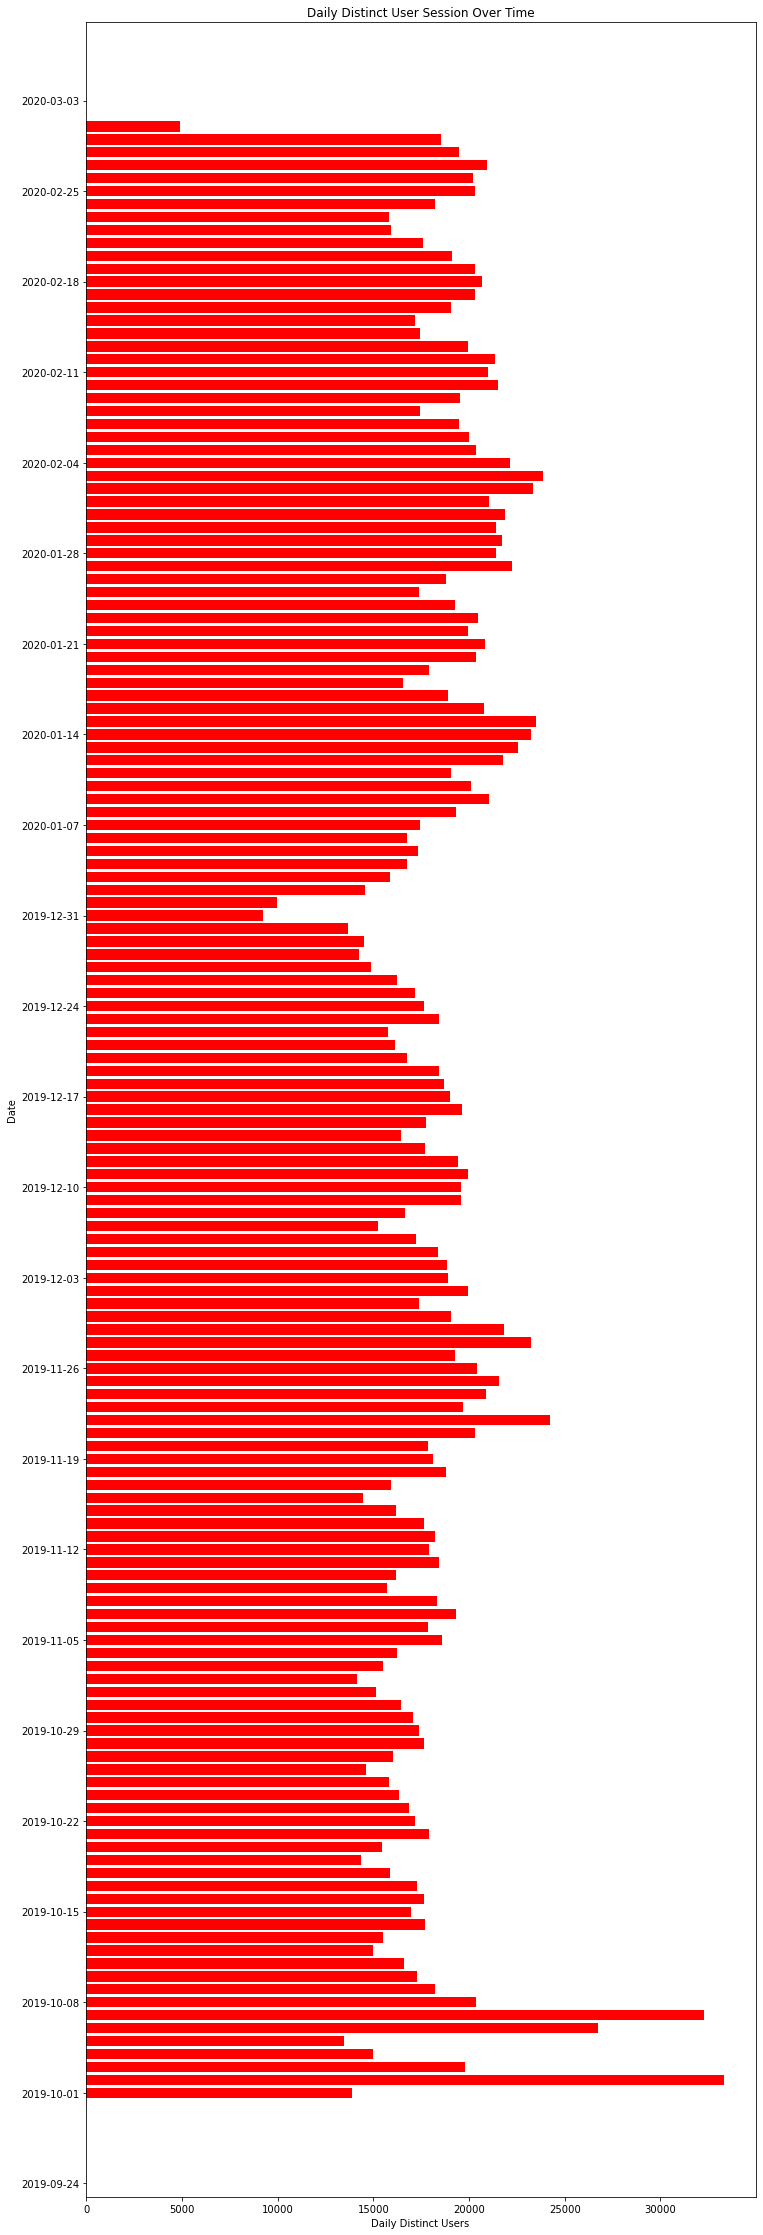

In [34]:
plt.figure(figsize=(12,40))

plt.barh(pandas_df_1['date'], pandas_df_1['distinct_users'], color='red')

plt.ylabel('Date')
plt.xlabel('Daily Distinct Users ')
plt.title('Daily Distinct User Session Over Time')

# This arrangement will display one date label per week 
plt.gca().yaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

In [35]:
# Average User Sessions Daily

In [36]:
df_daily_user = df.groupby("date", "user_id").agg(count("user_session").alias("sessions_per_user")).groupby("date").agg(avg("sessions_per_user").alias("avg_daily_user_session"))

In [37]:
df_daily_user.sort(desc("date")).show()

+----------+----------------------+
|      date|avg_daily_user_session|
+----------+----------------------+
|2020-03-01|     7.056352459016393|
|2020-02-29|     7.132977576541613|
|2020-02-28|     7.187072556178331|
|2020-02-27|     7.153250847943439|
|2020-02-26|     7.427405795668085|
|2020-02-25|     7.792986425339366|
|2020-02-24|     7.601087195255875|
|2020-02-23|     7.455080349234468|
|2020-02-22|     6.764369261728085|
|2020-02-21|     6.761904761904762|
|2020-02-20|      7.05983040201005|
|2020-02-19|    7.4462476640110165|
|2020-02-18|     7.238997052997729|
|2020-02-17|     7.147862028243861|
|2020-02-16|     7.227105650073514|
|2020-02-15|     7.023840055957099|
|2020-02-14|     7.174681510386779|
|2020-02-13|     7.335238095238095|
|2020-02-12|     7.651342612118656|
|2020-02-11|     7.125625744934446|
+----------+----------------------+


In [38]:
# Convert Spark DataFrame to pandas DataFrame
pandas_df = df_daily_user.toPandas()
pandas_df["date"] = pandas_df['date'].apply(lambda x: pd.to_datetime(x))

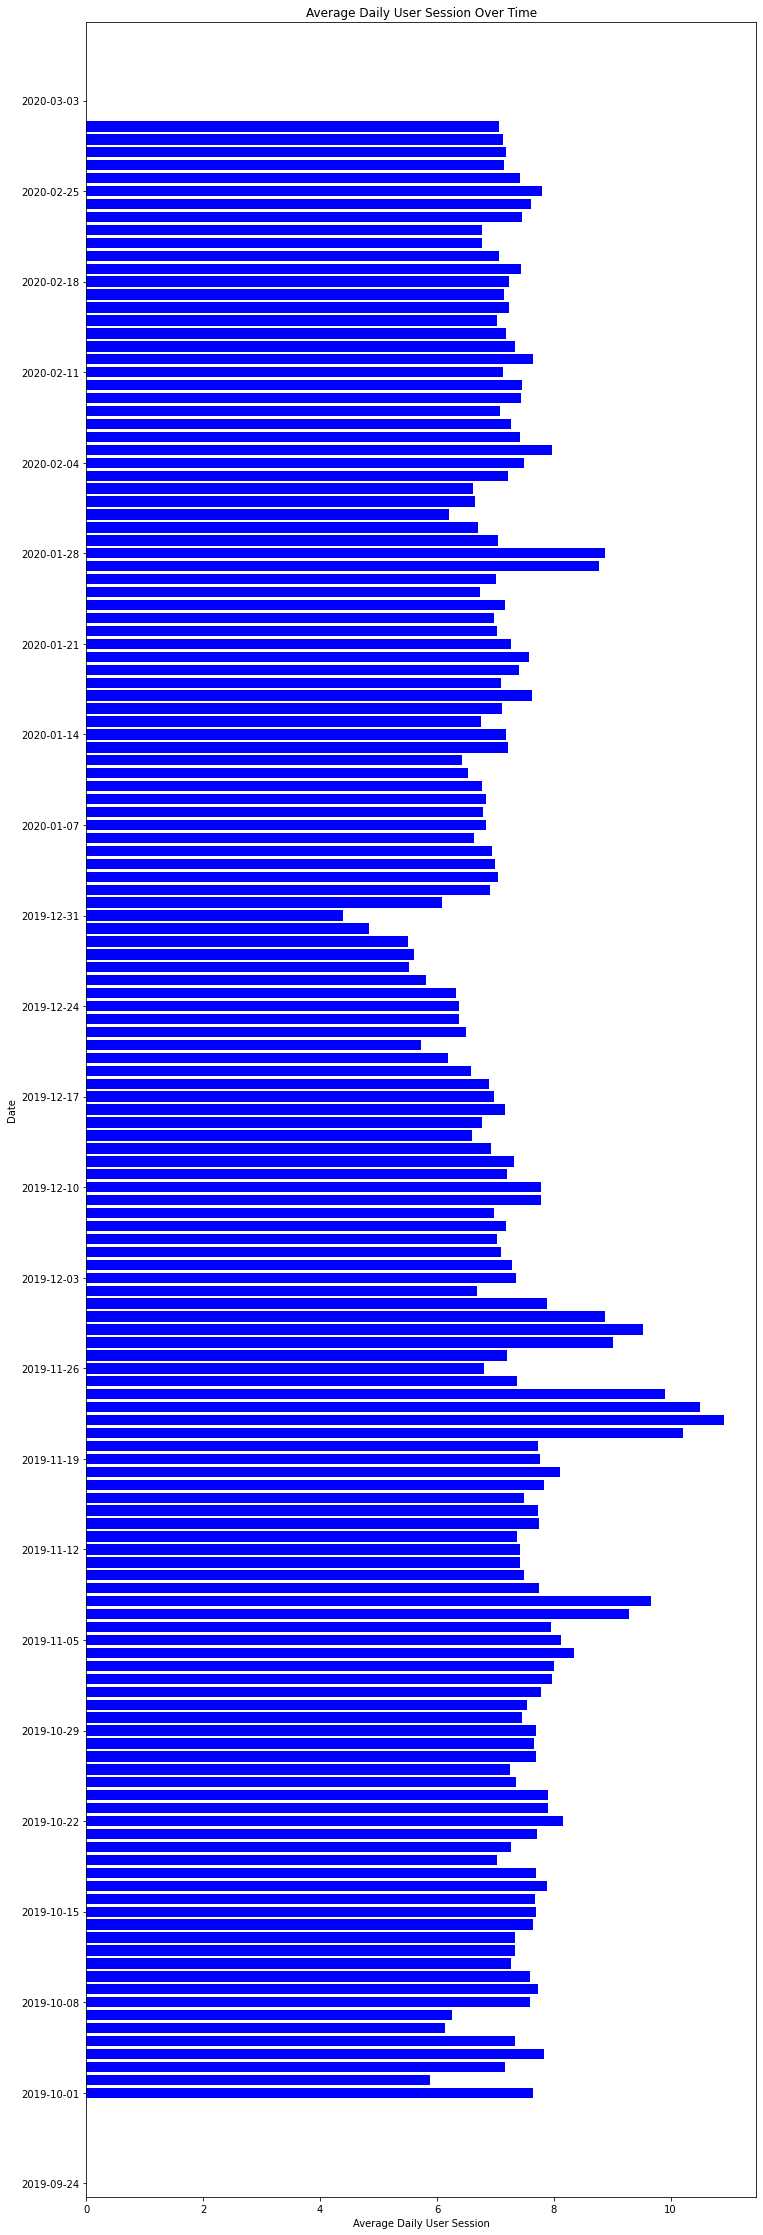

In [39]:
plt.figure(figsize=(12,40))

plt.barh(pandas_df['date'], pandas_df['avg_daily_user_session'], color='blue')

plt.ylabel('Date')
plt.xlabel('Average Daily User Session')
plt.title('Average Daily User Session Over Time')

# This arrangement will display one date label per week 
plt.gca().yaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

In [40]:
@udf(returnType=StringType())
def get_week(date_str):
    date_format = "%Y-%m-%d"  # adjust to your date format
    date = datetime.strptime(str(date_str), date_format)
    week_start = date - timedelta(days=date.weekday())
    week_end = week_start + timedelta(days=6)
    return week_start.strftime(date_format) + "/" + week_end.strftime(date_format)

In [41]:
df_with_week = df.withColumn('week', get_week(df['date']))

In [42]:
df_week_distinct_user = df_with_week.groupby("week").agg(countDistinct('user_id').alias("distinct_users"))

In [ ]:
df_week_distinct_user.sort(desc("week")).show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark-3.2.1-bin-hadoop3.2/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark-3.2.1-bin-hadoop3.2/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/mudit.rathore/opt/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


In [ ]:
# Convert Spark DataFrame to pandas DataFrame
pandas_df_3 = df_week_distinct_user.toPandas()
# pandas_df_3["week"] = pandas_df_3['week'].apply(lambda x: pd.to_datetime(x))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Sort the df by 'week' column
pandas_df_3 = pandas_df_3.sort_values('week')

# Creating the bar plot
plt.figure(figsize=(12,40))
plt.barh(pandas_df_3['week'].astype('str'), pandas_df_3['distinct_users'], color='green')

plt.ylabel('Week')
plt.xlabel('Weekly Distinct Users')
plt.title('Weekly Distinct User Session Over Time')

# This arrangement will display one date label per week 
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().invert_yaxis() # To display the earliest date at the bottom

plt.show()

# product sales across the month, max, avg, week of month 

# Working For User Session Related Data

In [49]:
#dropping the null in user_session
df_session_no_null = df.na.drop(subset=["user_session"])

In [50]:
df.groupBy("event_type").count().sort(desc("count")).show()

+----------------+-------+
|      event_type|  count|
+----------------+-------+
|            view|9657790|
|            cart|5764557|
|remove_from_cart|3978888|
|        purchase|1287007|
+----------------+-------+


In [51]:
df.groupBy("product_id").count().sort(desc("count")).show()

+----------+------+
|product_id| count|
+----------+------+
|   5809910|141561|
|   5809912| 55578|
|   5700037| 51097|
|   5802432| 45001|
|   5854897| 44778|
|   5751422| 43241|
|   5751383| 43104|
|   5815662| 41287|
|   5849033| 37630|
|   5809911| 36172|
|   5816170| 32208|
|   5792800| 31087|
|   5877454| 30289|
|   5686925| 28359|
|   5649236| 25009|
|   5528035| 24761|
|   5790563| 23821|
|   5877456| 23803|
|   5856186| 23762|
|      5304| 23729|
+----------+------+


In [52]:
df.groupBy("category_id").count().sort(desc("count")).show()

+-------------------+-------+
|        category_id|  count|
+-------------------+-------+
|1487580007675986893|1062619|
|1487580005595612013| 789423|
|1487580005092295511| 770878|
|1487580005671109489| 680617|
|1487580006317032337| 646659|
|1602943681873052386| 640727|
|1487580005268456287| 448730|
|1487580013841613016| 397879|
|1487580005134238553| 397102|
|1487580008246412266| 375079|
|1487580009286598681| 371270|
|1487580005754995573| 369210|
|1487580006300255120| 315299|
|1487580013950664926| 288392|
|1487580009445982239| 281941|
|1487580008145748965| 277481|
|1487580005713052531| 264503|
|1487580005511725929| 257261|
|1487580005427839846| 249260|
|1487580004916134735| 245277|
+-------------------+-------+


In [54]:
df.columns

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'date',
 'month',
 'year',
 'time',
 'day_of_week']

In [56]:
windowSpec = Window.partitionBy("user_id", "product_id").orderBy("event_time")

In [59]:
df = df.withColumn("prev_event_type", lag(df['event_type']).over(windowSpec))

In [60]:
# Define session transitions: view to cart, cart to purchase or remove from cart
df = df.withColumn('session_transition',
                   when((col('prev_event_type') == 'view') & (col('event_type') == 'cart'), 'view_to_cart')
                   .when((col('prev_event_type') == 'cart') &
                         ((col('event_type') == 'purchase') | (col('event_type') == 'remove_from_cart')), 'cart_to_purchase/remove')
                   .otherwise(None))

In [61]:
df.show()

+-------------------+----------------+----------+-------------------+-------------+----------+-----+---------+--------------------+----+-----+----+--------+-----------+----------------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|     brand|price|  user_id|        user_session|date|month|year|    time|day_of_week| prev_event_type|  session_transition|
+-------------------+----------------+----------+-------------------+-------------+----------+-----+---------+--------------------+----+-----+----+--------+-----------+----------------+--------------------+
|2019-10-10 19:41:28|            view|   5776130|1487580013472514244|         null|art-visage| 1.98|100015010|852f0890-41c4-487...|  10|   10|2019|19:41:28|        Thu|            null|                null|
|2020-02-04 13:20:46|            view|   5870963|1487580012809814181|         null|    masura| 7.44|101025416|d3023693-0657-4bc...|   4|    2|2020|13:20:46|        Tue|    

In [65]:
# Calculate number of sessions for each session transition.
df = df.groupBy('user_id', 'product_id', 'session_transition').agg(count('session_transition').alias('num_sessions')).sort(desc("num_sessions"))

+---------+----------+--------------------+------------+
|  user_id|product_id|  session_transition|num_sessions|
+---------+----------+--------------------+------------+
|531900924|   5809910|cart_to_purchase/...|          65|
|463646608|   5840415|cart_to_purchase/...|          38|
|471197852|   5809910|cart_to_purchase/...|          34|
|463646608|   5857959|cart_to_purchase/...|          33|
|570030304|   5809912|cart_to_purchase/...|          32|
|443045778|   5751422|cart_to_purchase/...|          31|
|236201323|   5700038|cart_to_purchase/...|          28|
|230818889|   5751422|cart_to_purchase/...|          27|
|463646608|   5887733|cart_to_purchase/...|          27|
|531900924|   5751422|cart_to_purchase/...|          27|
|463646608|   5688035|cart_to_purchase/...|          26|
|538069676|   5802432|cart_to_purchase/...|          24|
|463646608|   5688696|cart_to_purchase/...|          24|
|583947345|   5700035|cart_to_purchase/...|          24|
|463646608|   5732030|cart_to_p

In [67]:
# To find products that are in the same start (view_cart), simply filter results based on session transition
df_view_cart = df.filter(col('session_transition') == 'view_to_cart')

# Define a window that also includes session_transition
windowSpec2 = Window.partitionBy('user_id', 'product_id', 'session_transition').orderBy('event_time')

# Get the start and end dates for each session transition
df = df.withColumn('start_date', first(to_date('event_time')).over(windowSpec2))
df = df.withColumn('end_date', last(to_date('event_time')).over(windowSpec2))

In [66]:
# maximum session in a day,